In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


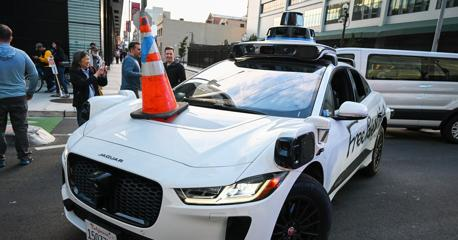

[Waymo sues anti-robotaxi neo-Luddites.](https://www.wired.com/story/waymo-sues-alleged-driverless-car-attackers/) - WIRED

___

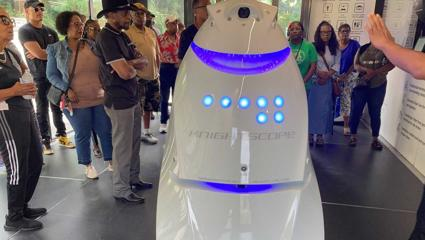

[Baltimore company shows off robo-cop surveillance device in a church.](https://www.wbaltv.com/article/crime-fighting-robots-showcased-church-baltimore-assist-police-danger/61712436) - WBAL

___

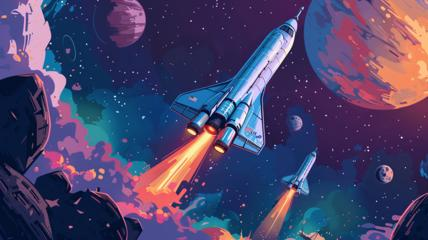

[say 'open source' and weirdos get a boner, but c'mon there is nothing very open source about a 405b-parameter model you run in AWS. The day might come where you can train and run and maintain your own decent local models, but not yet, and in no way is Zuck less creepy than Altman and Nadella.](https://venturebeat.com/ai/silicon-valley-shaken-as-open-source-ai-models-llama-3-1-and-mistral-large-2-match-industry-leaders/) - VentureBeat

___

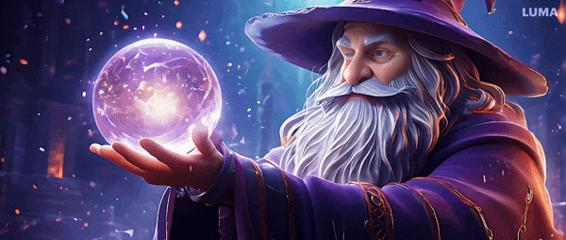

[Some cool AI tooling projects](https://hackernoon.com/these-13-hidden-open-source-libraries-will-help-you-become-an-ai-wizard)

___

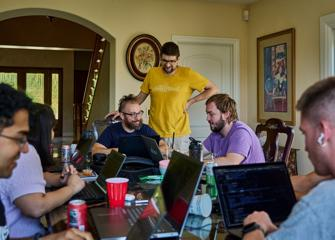

[DARPA contest to scan source code, find and fix security vulnerabilities. Leaders get more funding along the way and winner gets \\$2m.](https://www.washingtonpost.com/technology/2024/07/27/pentagon-cybersecurity-ai-hackathon-darpa-challenge/) - Washington Post

___

[No big deal, a bunch of nerds raised money from evil billionaires and bigcos and made a nuclear bomb.](https://www.nytimes.com/2024/07/27/opinion/ai-advances-risks.html)

___

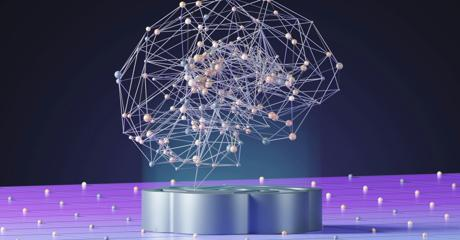

[Scientists study LLMs kind of like they study the brain. Try stuff and see what lights up.](https://www.vox.com/future-perfect/362759/ai-interpretability-openai-claude-gemini-neuroscience) - Vox

___

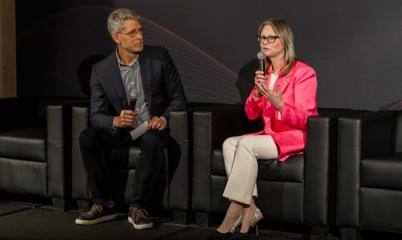

[Microsoft is trying to turning AI skeptics into AI power users](https://venturebeat.com/ai/how-microsoft-is-turning-ai-skeptics-into-ai-power-users/) - VentureBeat

___

[Will AI boyfriends kill pulp romance novels?](https://unherd.com/newsroom/ai-boyfriend-surge-is-the-endpoint-of-mills-boon/)

___

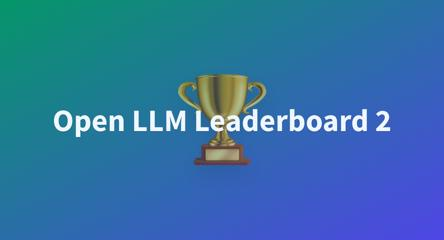

[Llama 3.1 didn't really improve in the benchmark leaderboard vs 3.0 and anyway human evals like LMSYS are what matters](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard)

___

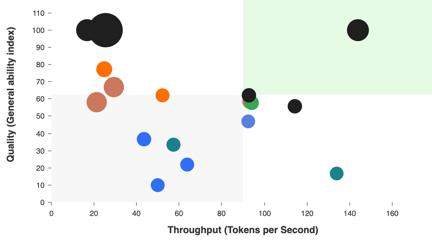

[About the same price as GPT-4o but slower](https://artificialanalysis.ai/models/llama-3-1-instruct-405b)

___

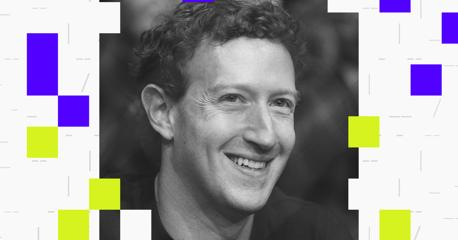

[Zuck is waging a campaign to blunt Google and OpenAI, and is hyping LLama 3.1 and the 405b-parameter model, but it's not significantly cheaper and faster than GPT-4o, nor have I seen benchmarks showing it's as good.](https://www.theverge.com/2024/7/26/24206274/the-ai-race-big-shift-models-to-products) - The Verge

___

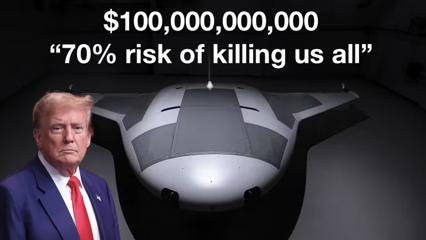

[Stephen Fry narrates a video about AI and how it will probably kill us all.](https://www.youtube.com/watch?v=-H7e4XlMgg0) - YouTube

___

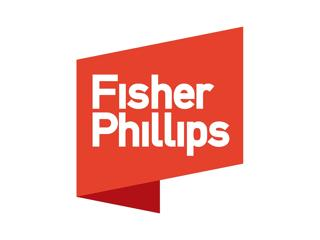

[Law firm reviews the best AI movies](https://www.jdsupra.com/legalnews/ai-in-the-movies-fp-reviews-the-best-1605152/) - JD Supra

___

[Get an exoskeleton assist on your hike.](https://www.fastcompany.com/91159743/skip-and-arcteryx-built-an-amazing-new-exoskeleton-heres-what-its-like-to-walk-in-it)

___

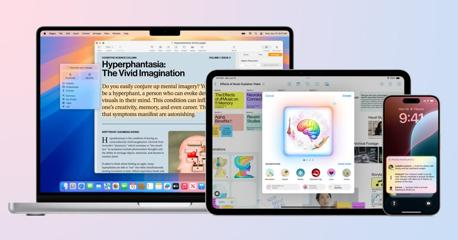

[Apple signs on to voluntary safety guidelines.](https://9to5mac.com/2024/07/26/apple-ai-biden-safety-guidelines/) - 9to5Mac

___

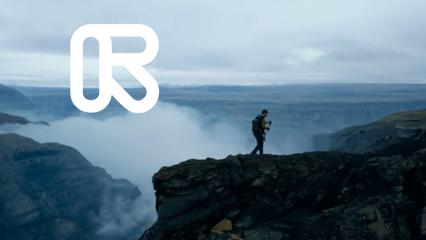

[Leaked docs suggest Runway trained on YouTube videos without permission.](https://www.404media.co/runway-ai-image-generator-training-data-youtube/) - 404 Media

___

[Amazon hypes its in-house AI silicon to compete with Nvidia](https://www.reuters.com/technology/artificial-intelligence/amazon-racing-develop-ai-chips-cheaper-faster-than-nvidias-executives-say-2024-07-25/)

___

[China Is Closing the A.I. Gap With the United States](https://www.nytimes.com/2024/07/25/technology/china-open-source-ai.html)

___

[Data centers use 2% of global power and AI is a fraction of that, total electricity demand in the US fell in 2023.](https://www.wsj.com/articles/can-innovation-curb-ais-hunger-for-power-e9c3d8bc)

___

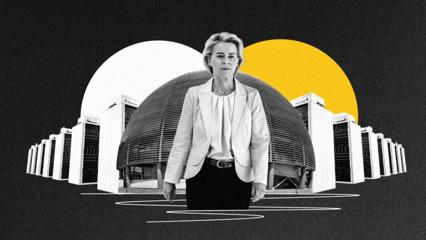

[EC President wants €100 billion over 5 to 7 years for 'CERN for AI'](https://www.euractiv.com/section/digital/news/von-der-leyen-gives-nod-to-e100-billion-cern-for-ai-proposal/) - www.euractiv.com

___

[Morgan Stanley rolls out AI to summarize meetings and auto-gen followups.](https://www.wsj.com/articles/morgan-stanley-moves-forward-on-homegrown-ai-120c59ab)

___

[Slop AI obituaries written for SEO compound survivors' grief.](https://www.fastcompany.com/91162990/ai-written-obituaries-are-compounding-peoples-grief)

___

[Sam Altman says alpha voice assistant rollout coming next week.](https://twitter.com/AIandDesign/status/1816552946378899629) - X (formerly Twitter)

___

[Scammer attempts to con Ferrari with CEO deepfake spearphish attack.](https://www.bloomberg.com/news/articles/2024-07-26/ferrari-narrowly-dodges-deepfake-scam-simulating-deal-hungry-ceo)

___

[FCC advances proposal to require disclosure of AI content in political ads, after FEC action was blocked by GOP.](https://www.courthousenews.com/proposed-fcc-rules-would-require-public-disclosure-when-political-ads-use-ai-generated-content/)

___

People are already highlighting stuff SearchGPT gets wrong.

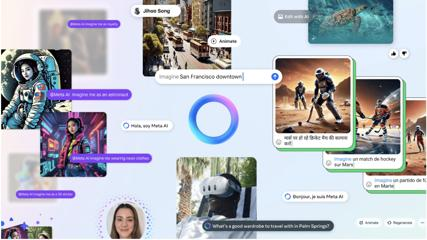

[Meta tests AI avatars, 'imagine me as an astronaut'](https://mashable.com/article/meta-new-imagine-me-feature) - Mashable

___

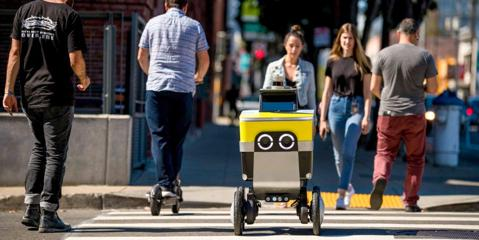

[Autonomous delivery robot company stock soars after Nvidia reveals investment.](https://markets.businessinsider.com/news/stocks/serve-robotics-stock-price-soars-nvidia-discloses-investment-stake-serv-2024-7) - Markets Insider

___

[JPMorgan rolled out an internal LLM suite for asset and wealth managers.](https://www.reuters.com/technology/artificial-intelligence/jpmorgan-launches-in-house-chatbot-ai-based-research-analyst-ft-reports-2024-07-26/)

___

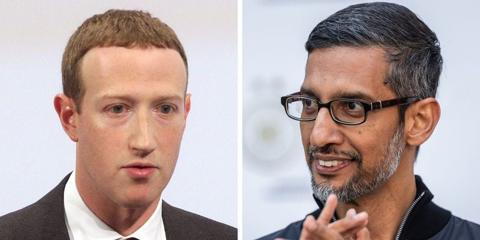

[Job losses in tech as CEOs fire workers to invest more in AI.](https://www.businessinsider.com/ai-job-losses-spending-new-tech-meta-google-amazon-layoffs-2024-7) - Business Insider

___

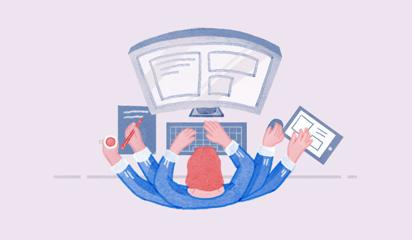

[Workers say AI in their jobs makes them less productive and adds to their workload.](https://www.worklife.news/technology/ai-is-actually-making-workers-less-productive/) - WorkLife

___

[Begun the robot dog wars have](https://www.reddit.com/r/oddlyterrifying/comments/1eb6lob/army_of_robot_dogs_tested/)

___

at risk of stating the obvious, it's 'Paul is dead' ridiculousness, not 'Dave' or 'Moon Over Parador' or 'Weekend at Bernies', and supposing he did enhance his voice or sign stuff with autopen who cares.

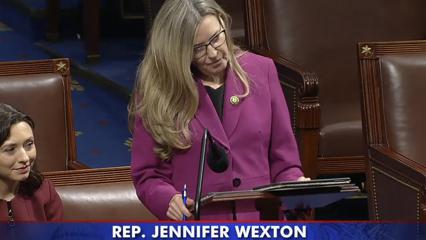

[Rep. Jennifer Wexton's spoke on the House Floor using ElevenLabs voice.](https://www.npr.org/2024/07/25/nx-s1-5051720/jennifer-wexton-ai-speech-progressive-supranuclear-palsy) - NPR

___

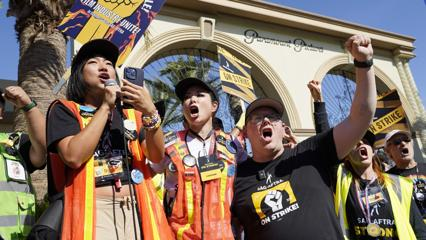

[Video game actors strike against AI.](https://apnews.com/article/sagaftra-video-game-performers-ai-strike-4f4c7d846040c24553dbc2604e5b6034) - AP News

___

[Rogan plays Biden call on air, AI detector says it's AI.](https://www.newsweek.com/joe-rogan-tests-bidens-kamala-harris-call-likely-ai-1930047)

___

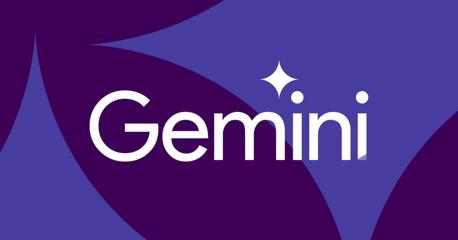

[Free Gemini got faster model, more features.](https://www.theverge.com/2024/7/25/24206071/google-gemini-ai-flash-upgrade) - The Verge

___

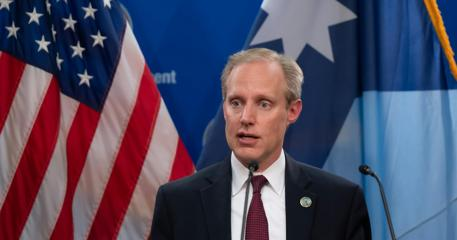

[Grok originated false info about election, shrugged when alerted to it.](https://www.startribune.com/xs-ai-chatbot-grok-spread-misinformation-about-minnesotas-ballots-does-the-tech-giant-care/600385945/) - Star Tribune

___

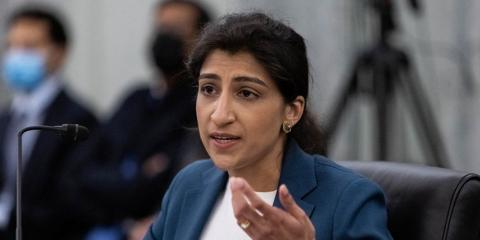

[Lina Khan addresses YC, says she likes open-weight models like Llama.](https://www.businessinsider.com/openness-in-ai-is-necessary-ftc-lina-khan-2024-7) - Business Insider

___

every so often he just tweets, haha, here's a fraud I'm committing everybody

[Murdoch to discuss a \\$5b transfer from his 13%-owned publicly held Tesla to his private company with the board, which consists of his brother, James Murdoch, the AirBnB designer, and some nobodies.](https://www.reuters.com/technology/artificial-intelligence/musk-discuss-5-billion-xai-investment-with-tesla-board-2024-07-25/)

___

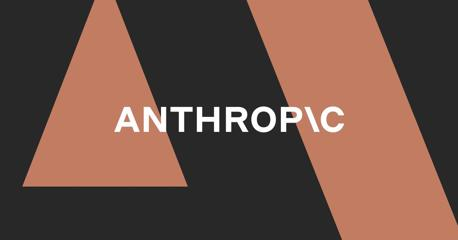

[iFixit says Claude's scraper is rudely ignoring robots.txt and DOSing it](https://www.theverge.com/2024/7/25/24205943/anthropic-ai-web-crawler-claudebot-ifixit-scraping-training-data) - The Verge

___

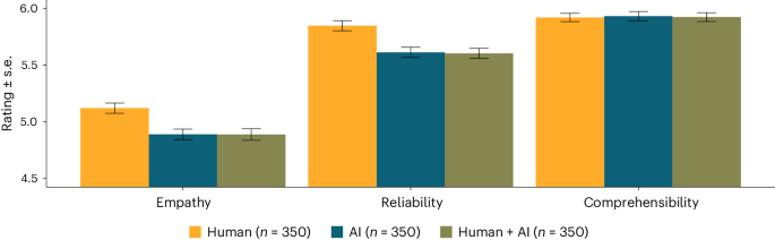

[Patients don't trust medical advice it they are told it comes from AI.](https://www.nature.com/articles/s41591-024-03180-7) - Nature

___

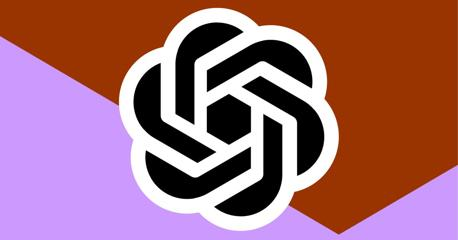

[SearchGPT is real and it’s fabulous](https://www.theverge.com/2024/7/25/24205701/openai-searchgpt-ai-search-engine-google-perplexity-rival) - The Verge

___

[Move Over, Mathematicians, Here Comes AlphaProof](https://www.nytimes.com/2024/07/25/science/ai-math-alphaproof-deepmind.html)

___

[Google releases models for math that it says can solve International Math Olympiad problems](https://x.com/GoogleDeepMind/status/1816498082860667086) - X (formerly Twitter)

___

Via Allie Miller ... this video is one way to get to stage 4, and stack a series of AI steps like categorization, summarization, content generation.

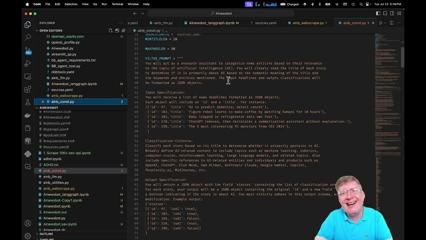

[I made a video about how to build a news aggregator with LangGraph -](https://www.youtube.com/watch?v=9Y_uLVaugWM) - YouTube

___

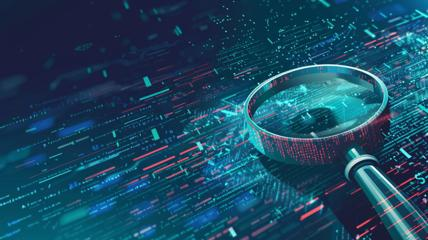

[Free fine-tuning for GPT-4o mini is kind of cool, for instance if you have a corpus of headlines to categorize.](https://venturebeat.com/ai/ai-arms-race-escalates-openai-offers-free-gpt-4o-mini-fine-tuning-to-counter-metas-llama-3-1-release/) - VentureBeat

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
print(datetime.now())

2024-07-27 12:18:14.993221


In [12]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 27, 15, 24, 16, 226000)

In [13]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-26 06:18:14.999906


In [14]:
sqlite

NameError: name 'sqlite' is not defined